# Seminar 5 - Significance tests

## Sleep data
The effect of the drugs was measured individually for each participant by how many hours the sleep was prolonged compared to the participant’s normal sleep duration (column extra).

### Tasks
1. Load the dataset into your workspace using data(sleep).
2. Produce a violin plot that shows the extra sleep duration of both groups side-by-side. As there are only few patients tested in each treatment group add the individual observations as points onto the violin plot.

In [1]:
data(sleep)

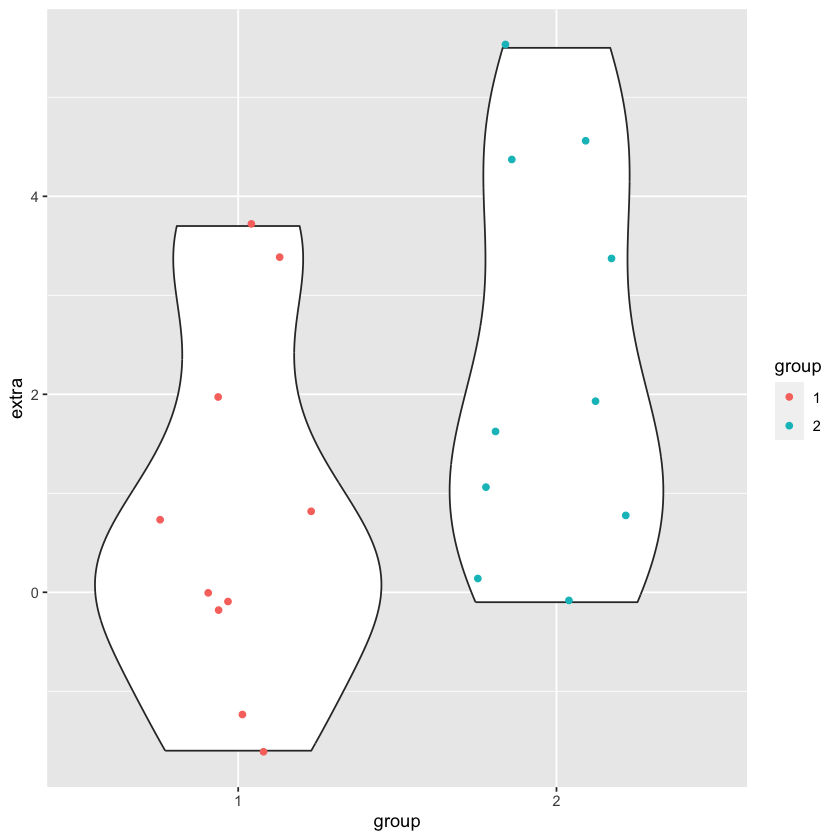

In [72]:
library("ggplot2")

ggplot(sleep, mapping = aes(x = group, y = extra)) +
    geom_violin() +
    geom_jitter(width = 0.25, aes(colour = group))

3. Assume that the extra time within both groups is sufficiently close to a normal distribution. Do a suitable significance test that compares the expected value of extra time between both groups.
4. Interpret the results at a significance level of $α =$ 5%.

In [257]:
alpha_sleep = 0.05

t.test(extra ~ group, 
       data = sleep, 
       var.equal = FALSE, 
       paired = FALSE,
       conf.level = 1 - alpha_sleep)


	Welch Two Sample t-test

data:  extra by group
t = -1.8608, df = 17.776, p-value = 0.07939
alternative hypothesis: true difference in means between group 1 and group 2 is not equal to 0
95 percent confidence interval:
 -3.3654832  0.2054832
sample estimates:
mean in group 1 mean in group 2 
           0.75            2.33 


5. You learn that the experiment was actually done as a cross-over study, i.e., each participant was measured for both drugs and the order that participants receive the drugs was randomized. In the sleep data set, the participant’s identity is recorded in column ID. Does this additional information influence your answer to the previous question?

In [83]:
library("coin")
wilcox_test(extra ~ group, data = sleep, conf.level = 1 - alpha_sleep)


	Asymptotic Wilcoxon-Mann-Whitney Test

data:  extra by group (1, 2)
Z = -1.8541, p-value = 0.06372
alternative hypothesis: true mu is not equal to 0


#### Mistakes

In [55]:
group_1 = subset(sleep, group == "1")
group_2 = subset(sleep, group == "2")

mean_g1 = mean(group_1$extra)
mean_g2 = mean(group_2$extra)

std_g1 = sqrt(var(group_1$extra))
std_g2 = sqrt(var(group_2$extra))

In [56]:
type1_err_alpha <- function(x, mean, sd, a) abs(
    integrate(dnorm, lower = -Inf, upper = x, mean = mean, sd = std_g1)$value + a - 1 
)

intercept_g1 <- optimize(type1_err_alpha, 
    interval = c(mean_g1, mean_g1 + 5 * std_g1),
    mean = mean_g1,
    sd = std_g1,
    a = alpha_sleep
)$minimum

intercept_g2 <- optimize(type1_err_alpha,
    interval = c(mean_g2, mean_g2 + 5 * std_g2),
    mean = mean_g2,
    sd = std_g2,
    a = alpha_sleep
)$minimum

intercept_g1
intercept_g2

[1] 3.692649

[1] 5.272666

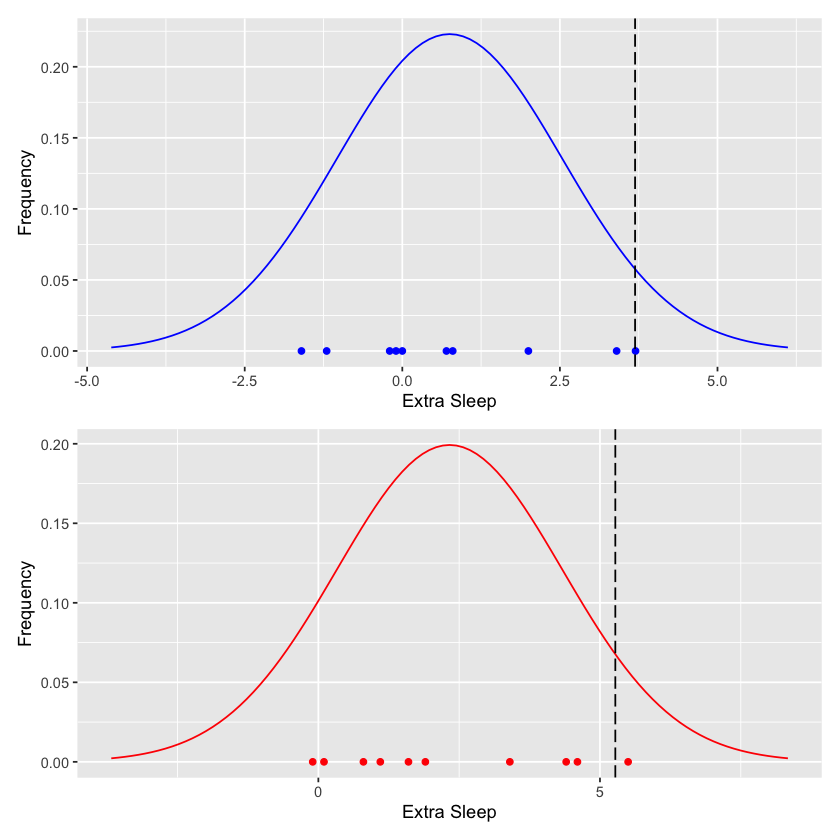

In [58]:
library("patchwork")

dist_g1 <- ggplot() + xlim(mean_g1 - 3 * std_g1, mean_g1 + 3 * std_g1) + 
    stat_function(fun = dnorm, args = list(mean = mean_g1, sd = std_g1), color = "blue") +
    geom_point(group_1, mapping = aes(x = extra, y = 0), color = "blue") +
    geom_vline(xintercept = intercept_g1, linetype = "longdash") +
    labs(x = "Extra Sleep", y = "Frequency")

dist_g2 <- ggplot() + xlim(mean_g2 - 3 * std_g2, mean_g2 + 3 * std_g2) + 
    stat_function(fun = dnorm, args = list(mean = mean_g2, sd = std_g2), color = "red") +
    geom_point(group_2, mapping = aes(x = extra, y = 0), color = "red") +
    geom_vline(xintercept = intercept_g2, linetype = "longdash") +
    labs(x = "Extra Sleep", y = "Frequency")
    
dist_g1 + 
dist_g2 + 
plot_layout(ncol = 1)

In [59]:
subset(group_1, extra > intercept_g1)
subset(group_2, extra > intercept_g2)

,extra,group,ID
,<dbl>,<fct>,<fct>
7,3.7,1,7


,extra,group,ID
,<dbl>,<fct>,<fct>
17,5.5,2,7


## Lung cancer
In a clinical trial, a new treatment is tested on N=811 patients with early stage lung cancer. Of these, y=521 are still alive after five years.

Your task is to perform the following two statistical significance tests. When we apply a 5%-significance level, do you draw different conclusions?

In [66]:
N_patients = 811
y_alive = 521
pi_0 = 0.6
alpha_cancer = 0.05

### 1. Binomial test
In the lecture, you have seen the exact binomial test which fits the described above situation.

1. What is the probability mass of the observed outcome under H0?
2. Which of the binomial outcomes (0, 1, …, 811) contribute to the resulting P-value of this binomial test?
3. What is this P-value?

In [84]:
p_binomial <- function(x, n, h) {
    choose(n, x) * (h ^ x) * ((1 - h) ^ (n - x))
}

p_mass_success = p_binomial(y_alive, n = N_patients, h = pi_0)
p_mass_success

probs <- c()
for (i in c(1:N_patients)) {
    p_mass = p_binomial(i, n = N_patients, h = pi_0)
    if (p_mass <= p_mass_success) {
        probs <- c(p_mass, probs)
    } 
}

length(probs)
print(paste("Calc. P-value", sum(probs)))

[1] 0.001342429

[1] 742

[1] "Calc. P-value 0.0134095600748631"


In [85]:
binom.test(521, n = N_patients, p = pi_0, conf.level = 1 - alpha_cancer) # check value


	Exact binomial test

data:  521 and N_patients
number of successes = 521, number of trials = 811, p-value = 0.01341
alternative hypothesis: true probability of success is not equal to 0.6
95 percent confidence interval:
 0.6083431 0.6754508
sample estimates:
probability of success 
             0.6424168 


### 2. Likelihood ratio test

$ λ_{LR} = −2·(sup_{θ ∈ ω} ln L(θ) − sup_{θ ∈ Ω} ln L(θ)) $

1. What is the value of the test statistic $λ_{LR}$?
2. What is the corresponding asymptotic P-value?


In [255]:
# Likelihood ratio
-2 * log(
    p_binomial(x = y_alive, n = N_patients, h = pi_0) /
    p_binomial(x = y_alive, n = N_patients, h = y_alive/N_patients)
)

[1] 6.16062

## Voting Habits

Survey outcome on political preference in the US between males and females
|        | Democrat | Independent | Republican |
| ------ | -------: | ----------: | ---------: |
| Female | 762      | 327         | 468        |
| Male   | 484      | 239         | 477        |

### Tasks
1. Apply a suitable statistical significance test to assess if gender and political party preference is independent in the surveyed population? Interpret the test results at a significance level of $α$ = 5%.
2. Specifically, consider the association of preferring the Republican party and gender. Estimate this association with the odds ratio (OR) where you use females as reference group.

In [141]:
alpha_voters = 0.05
voters <- data.frame(
    male = c(484, 239, 477),
    female = c(762, 327, 468))

voters
chisq.test(voters)

male,female
<dbl>,<dbl>
484,762
239,327
477,468



	Pearson's Chi-squared test

data:  voters
X-squared = 30.07, df = 2, p-value = 2.954e-07


In [258]:
odds_ratio <- function(party) {
    (voters$male[party]   / (sum(voters$male) - voters$male[party])) /
    (voters$female[party] / (sum(voters$female) - voters$female[party]))
}

odds_ratio(party = 3)

[1] 1.53519

## Sleep data revisited
Consider again the sleep-data from the beginning, but this time you are asked to apply a randomization test which belongs to conditional inference (see lecture). This means: you condition on these observed values and you infer directly from there through permutations and without using any distributional assumptions.



### Unpaired samples
We first treat the data as unpaired, i.e., we ignore that the same participant is measured twice, once for drug 1 and once for drug 2.

1. As test statistic choose, the mean difference in the two groups (exactly like in the roomwidth-example in the lecture). The conditional distribution of the test statistic under the null hypothesis H0: «no difference in expected value» — given the observed data — is built by shuffling the outcome (extra sleep time) which in fact breaks any possible link between the group variable and the outcome. Implement this shuffling (in R). Set the seed to some fixed number so that the pseudo-random generator gives reproducible results and run the shuffling e.g. B=9999 times and each time compute the test statistic on the shuffled data. The two-sided P-value of the randomization test is the proportion of test statistics that are in absolute value at least as far away from zero as the initially observed test statistic. Compare your proportion with the P-value from the parametric independent sample test you did above.
2. Repeat your procedure from the previous step, but this time choose a simpler test statistic: the sum of extra-time in the «drug 1»-group. Compare the two P-values from the previous and this randomization test. Discuss your finding.

In [221]:
set.seed(1234)

mean_diff <- function (df) {
    group_1 = subset(df, group == "1")
    group_2 = subset(df, group == "2")
    mean(group_1$extra) - mean(group_2$extra)
}

[1] "P-Value 0.0823082308230823"


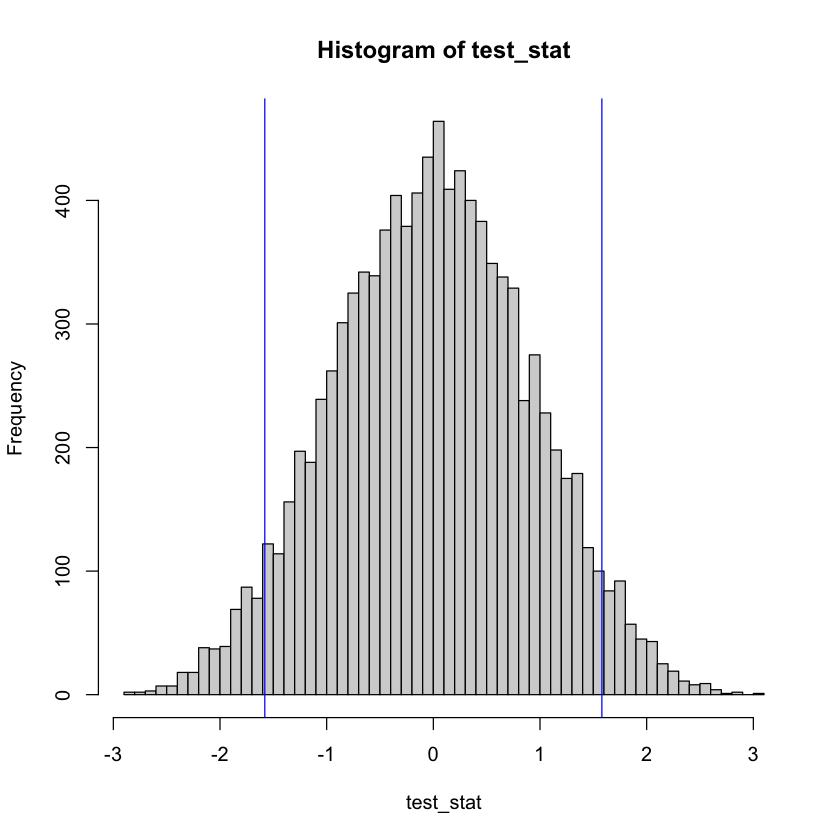

In [230]:
B <- 9999
sleep_shuffle <- sleep
init_mean_diff <- abs(mean_diff(sleep_shuffle))

prop <- 0
test_stat <- c()
for (i in c(1:B)) {
    sleep_shuffle$extra <- sample(sleep_shuffle$extra)
    diff <- mean_diff(sleep_shuffle)
    test_stat <- c(diff, test_stat)
    if (init_mean_diff < abs(diff)) {
        prop <- prop + 1
    }
}

print(paste("P-Value", prop/B))
hist(test_stat, breaks = 50)
abline(v = init_mean_diff, col = "blue")
abline(v = -init_mean_diff, col = "blue")

[1] "P-Value 0.097009700970097"


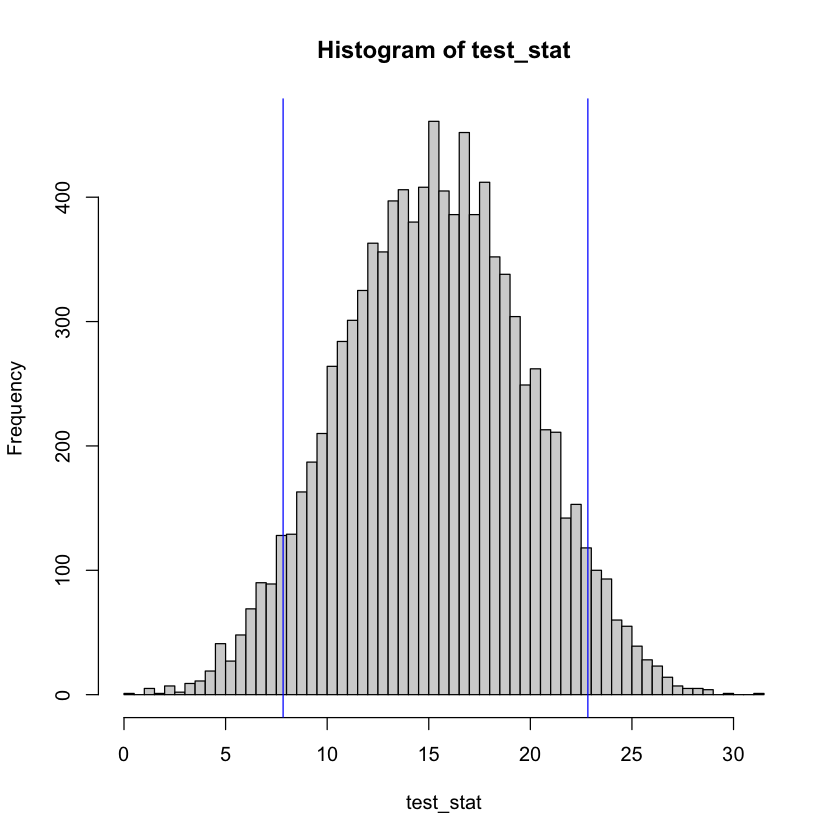

In [238]:
sum_group <- function(df, g) {
    sum(subset(df, group == g)$extra)
}

B <- 9999
sleep_shuffle <- sleep
init_sum <- abs(sum_group(sleep_shuffle, "1"))

prop <- 0
test_stat <- c()
for (i in c(1:B)) {
    sleep_shuffle$extra <- sample(sleep_shuffle$extra)
    s <- sum_group(sleep_shuffle, "1")
    test_stat <- c(s, test_stat)
    if (init_sum < abs(s - mean(test_stat))) {
        prop <- prop + 1
    }
}

print(paste("P-Value", prop/B))
hist(test_stat, breaks = 50)
abline(v = mean(test_stat) - init_sum, col = "blue")
abline(v = mean(test_stat) + init_sum, col = "blue")

### Paired samples
Implement this conditional randomization test and compare the resulting P-value with the P-value of the paired t-test.